#**Required packages**

In [1]:
!pip install langchain_core langchain_community langgraph langchain_groq langchain_huggingface langchain-chroma


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

# pydantic for structured o/p
from pydantic import BaseModel, Field

# Graph
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

# model and embedding
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

##**LLM and Embedding**

In [3]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = getpass.getpass()

··········


In [4]:
from google.colab import userdata

# hf_token = userdata.get('HF_TOKEN')
groq_api_key = userdata.get('groq_api_key')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

In [20]:
# llm model
llm=ChatGroq(groq_api_key=groq_api_key,
             model="deepseek-r1-distill-llama-70b")

# # embedding model
# embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")



#**Tavily tool**

In [6]:
tavily_tool = TavilySearchResults()


In [21]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

In [22]:
tools = [get_city_details]
model_with_tools = llm.bind(tools=tools)
tool_node=ToolNode(tools)

#**Pydantic class**
for Structured output

In [23]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [24]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [25]:
model_with_structured_output = llm.with_structured_output(CityDetails)


In [26]:
model_with_structured_output.invoke("what is the capital of Egypt?")

CityDetails(state_name='Egypt', state_capital='Cairo', country_name='Egypt', country_capital='Cairo')

#**Workflow Functions**

In [27]:
def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [28]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]

    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "responding from llm"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue for Tool calling"

In [29]:
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

##**Workflow nodes**

In [30]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

# Set the entrypoint
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges("llm",
                               should_continue,
                              {
                                  "continue for Tool calling": "tools",
                                  "responding from llm": "respond",
                              })

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

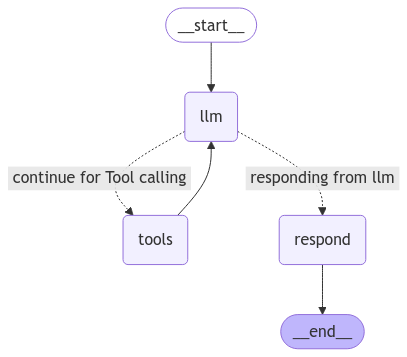

In [31]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

#**Test**

In [35]:
answer = graph.invoke(input={"messages": [("human", "who is the most famous football player")]})['final_response']
answer